In [2]:
import h5py 
import scipy 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit
from scipy import stats
import os
import spts
import sys
import pandas as pd
import spts.camera
from spts.camera import CXDReader

In [3]:
def make_circle_mask(diameter):
    center = (diameter-1.) / 2.
    x,y = np.meshgrid(np.arange(diameter), np.arange(diameter))
    rsq = (x-center)**2 + (y-center)**2
    mask = rsq <= center**2
    return mask

def combine_datafiles(filelist): 
    '''
    input:
    filelist - list of directory and filenames of the analysed and to be combined spts.cxi files
    
    output:
    [0]: hits_correctedall - array with length len(filelist)
    [1]: hitxall - array with length len(found particles)
    [2]: hityall - array with length len(found particles)
    [3]: hits_correctedall_single - array with length len(found particles)
    [4]: hitframeall - array with length len(found particles)
    - opens spts.cxi file
    - ignores hits with intensity < 0
    - NO FURTHER REMOVAL OF PARTICLES DONE HERE
    '''
    
    n_data = len(filelist)
    hits_corrected = []
    hits_correctedall = []
    hits_correctedall_single = []
    hitxall = []
    hityall = []
    hitframeall = []
    
    for i in range(n_data):
            
        f_name = filelist[i]
        print(i+1, '/',n_data, f_name)

        hits = 0  
        frames = 0 
        hit_intensity = 0 
        hit_intensities = np.empty(shape = (0)) 
        hit_x = np.empty(shape = (0)) # array for storing x-location of hit 
        hit_y = np.empty(shape = (0)) # array for storing y-location of hit 
        hit_frame = np.empty(shape = (0), dtype = int) # array for storing frame number of hits 

        f = h5py.File(f_name, 'r')

        frames += f['/5_detect/n'].shape[0] 
        hits += np.sum(f['/5_detect/n'])
        hits_per_frame = np.array(f["/5_detect/n"])

        #print('Number of frames:', frames) 
        #print('Number of raw hits:', hits) 

        for i in range(0, f['/5_detect/x'].shape[0]): # frame counter 
            for j in range(0, f['/5_detect/n'][i]): # particle counter 
                if f['/6_analyse/peak_sum'][i, j] > 0: # ignore hits with intensity lower than zero 
                    hit_x = np.append(hit_x, f['/5_detect/x'][i, j]) 
                    hit_y = np.append(hit_y, f['/5_detect/y'][i, j]) 
                    hit_frame = np.append(hit_frame, i)
                           
        a = np.array(f['/6_analyse/peak_sum']) 
        real_hits = np.sum((a > 0)) 
        #print('Number of real hits (intensity > 0):', real_hits) 
        #print()
        hit_intensities = np.append(hit_intensities, a[a > 0]) 

        sat_pix = np.array(f["/1_raw/saturated_n_pixels"])
        success_pix = np.array(f["/1_raw/success"])

        num_saturated_pixels = np.sum(sat_pix[sat_pix != 0])

        num_saturated_frames = np.sum(success_pix == 0)
        num_nonsaturated_frames = np.sum(success_pix == 1)

        fraction_saturated = num_saturated_frames / num_nonsaturated_frames

        #print("Number of saturated pixels: %s" % (num_saturated_pixels))
        print("Number of saturated frames: %s/%s" % (num_saturated_frames, frames))
        #print("Number of non-saturated frames: %s/%s" % (num_nonsaturated_frames,frames))
        #print("Percentage of saturated frames: %.4s%%" % (fraction_saturated*100))

        av_intensity = np.mean(hit_intensities) 
        med_intensity = np.median(hit_intensities) 
        std_intensity = np.std(hit_intensities) 
        min_intensity = np.min(hit_intensities) 
        max_intensity = np.max(hit_intensities) 
        mad_intensity = scipy.stats.median_abs_deviation(hit_intensities)

        hits_corrected, hitx, hity, hitframe = [], [], [], []
        hits_remain, hits_del = 0, 0
        for h in range(len(hit_intensities)): 
            hit_h = hit_intensities[h] 
            hx, hy, hf = hit_x[h], hit_y[h], hit_frame[h]
            if hit_h >= 0 : 
                hitx.append(hx) 
                hity.append(hy) 
                hitframe.append(hf)
                hits_corrected.append(hit_h) 
                hits_remain += 1
            else:
                hits_del += 1

        hits_corrected = np.array(hits_corrected)
        hitx = np.array(hitx) 
        hity = np.array(hity) 
        hitframe = np.array(hitframe)
            
        hits_correctedall = np.append(hits_correctedall, np.median(hits_corrected**(1/6))) # appends median sixths root intensity
        hits_correctedall_single = np.append(hits_correctedall_single, hits_corrected**(1/6)) # appends all sixths root hit intensities
        hitxall = np.append(hitxall, hitx) # all hit x-positions
        hityall = np.append(hityall, hity) # all hit y-positions
        hitframeall = np.append(hitframeall, hitframe) # all hit frame numbers
        
    return hits_correctedall, hitxall, hityall, hits_correctedall_single, hitframeall

def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def plot_DMA(filename, datanumber):
    with open(filename, "rb") as f:
        list1 = []
        for line in f:
            list1 = np.append(list1, line)
            #print(line)

    #load all lines including actual data into list2. Neglecting all supporting 
    #        information from the txt file. 
    list2 = []
    for i in range(21, np.shape(list1)[0]-27):   
        list2 = np.append(list2, list1[i].astype(str))

    #generating a 2D array from list2
    arr=list2
    sample = np.zeros((len(arr),len(arr[0].split("\t")) ))
    for i in range(len(arr)):
        #print(arr[i])
        sample[i] = arr[i].split("\t")

    diameter = sample[:,0]
    s = datanumber
    
    return diameter, sample[:,s]

def linear(x, a):
    return a*x


def files_from_folder(folderpath, log_path, exclude = []):
    #create list of files ending with "cxi" in folderpath
    files = [f for f in os.listdir(folderpath) if f.endswith('.cxi')]
    
    files = [f for f in files if f not in exclude]

    try:
        log = pd.read_csv(log_path)
    except Exception as e:
        print(f"Could not find log file at path: {log_path}. {e}")
        sys.exit(1)

    # Function to change the ending of the values
    def change_ending(value, old_ending, new_ending):
        if pd.notna(value) and value.endswith(old_ending):
            return value[:-len(old_ending)] + new_ending
        return value
    
    # Apply the function to specific columns
    log['File'] = log['File'].apply(change_ending, args=('.cdx', '.cxd'))

    files_dict = {}
    for file in files:
        row = log.loc[log['File'].str[:-4] == file[:9]]
        description = row['Description'].values[0]
        if description in files_dict:
            files_dict[description].append(folderpath + file)
        else:
            files_dict[description] = [folderpath + file]

    #sort dictionary by key alphabetically
    files_dict = dict(sorted(files_dict.items()))

    return files_dict

def combine_lists(files):
    particles_list = []
    for key in files:
        particles_list.append(combine_datafiles(files[key]))

    return particles_list

In [4]:
files_w05 = files_from_folder(   "/home/rwendl/data/he_esi_aug23/spts_he_esi_aug23_w05/",
                                                "/home/rwendl/data/consts/scatter_log.csv")

files_w25 = files_from_folder(   "/home/rwendl/data/he_esi_aug23/spts_he_esi_aug23_w25/",
                                                "/home/rwendl/data/consts/scatter_log.csv")

#print(files_w05)
#print(files_w25)

#print first element of dict files_w05
#print(files_w05[list(files_w05.keys())[0]])

particles_w05 = combine_lists(files_w05)
particles_w25 = combine_lists(files_w25)

1 / 8 /home/rwendl/data/he_esi_aug23/spts_he_esi_aug23_w05/data02370_ana_w05.cxi
Number of saturated frames: 0/2000
2 / 8 /home/rwendl/data/he_esi_aug23/spts_he_esi_aug23_w05/data02373_ana_w05.cxi
Number of saturated frames: 0/2000
3 / 8 /home/rwendl/data/he_esi_aug23/spts_he_esi_aug23_w05/data02376_ana_w05.cxi
Number of saturated frames: 2/2000
4 / 8 /home/rwendl/data/he_esi_aug23/spts_he_esi_aug23_w05/data02372_ana_w05.cxi
Number of saturated frames: 0/2000
5 / 8 /home/rwendl/data/he_esi_aug23/spts_he_esi_aug23_w05/data02371_ana_w05.cxi
Number of saturated frames: 0/2000
6 / 8 /home/rwendl/data/he_esi_aug23/spts_he_esi_aug23_w05/data02378_ana_w05.cxi
Number of saturated frames: 0/2000
7 / 8 /home/rwendl/data/he_esi_aug23/spts_he_esi_aug23_w05/data02377_ana_w05.cxi
Number of saturated frames: 1/2000
8 / 8 /home/rwendl/data/he_esi_aug23/spts_he_esi_aug23_w05/data02374_ana_w05.cxi
Number of saturated frames: 0/2000
1 / 3 /home/rwendl/data/he_esi_aug23/spts_he_esi_aug23_w05/data02365_ana

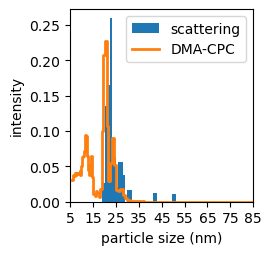

number of focused particles in ROI: 53
--------------------


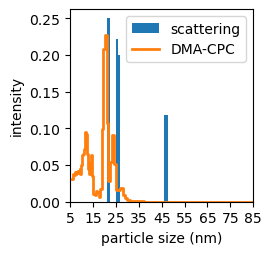

number of focused particles in ROI: 5
--------------------


In [ ]:
particles = particles_w25
particles2 = particles_w05

DMA_data = ['/home/rwendl/data/dma/AIM50.txt',
            '/home/rwendl/data/dma/AIM50.txt',]

number = [2,2,12,17]
Limit = 0.9
YLim = 300 
ylim = 100 

factor = 0.187 #Factor from calibration data (slope)

for m in range(len(particles)):
    sample = particles[m]
    sample2 = particles2[m]
    
    DMAx, DMAy = plot_DMA(DMA_data[m], number[m])
    
    focused = []
    focused_out = []
    unfocused = []
    focused_pos1 = []
    focused_pos2 = []
    for i in range(len(sample[4])-1):
        if sample[4][i] == sample2[4][i]:
            if sample[1][i] == sample2[1][i]:
                if sample[3][i] >= sample2[3][i] >= Limit*sample[3][i]: #select particles in laser focus position y range
                    if (sample[2][i]<YLim)&(sample[2][i]>ylim):
                        focused = np.append(focused, sample[3][i])
                        focused_pos1 = np.append(focused_pos1, sample[2][i])
                        focused_pos2 = np.append(focused_pos2, sample[1][i])
                    else:
                        focused_out = np.append(focused_out, sample[3][i])

                else:
                    unfocused = np.append(unfocused, sample[3][i])
        else:
            j = np.where(sample2[4] == sample[4][i])[0][0]  #index, where the small circle data == large circle data, 
                                                        # j = 2, i = 0
            if sample[1][i] == sample2[1][j]:
                if sample[3][i] >= sample2[3][j] >= Limit*sample[3][i]: #select particles in laser focus position y range
                    if (sample[2][i]<YLim)&(sample[2][i]>ylim):
                        focused = np.append(focused, sample[3][i])
                        focused_pos1 = np.append(focused_pos1, sample[2][i])
                        focused_pos2 = np.append(focused_pos2, sample[1][i])
                    else:
                        focused_out = np.append(focused_out, sample[3][i])
                else:
                    unfocused = np.append(unfocused, sample[3][i])  

    sizes = focused/factor
    
    plt.figure(figsize = (5, 6))
    plt.hist(sizes, bins = DMAx, range = (0, 80), density = True, histtype = "bar", linewidth = 2, label="scattering")
    plt.xlabel("particle size (nm)")
    plt.ylabel("intensity")
     
    plt.step(DMAx, DMAy/np.sum(DMAy[28:]), "-", linewidth = 2, where = 'pre', label = "DMA-CPC")
    plt.xlim(5, 85)
    plt.xticks(np.arange(5, 86, 10))
    
    plt.legend()
    #plt.savefig("Figure_new_%s.pdf"%(m))
    plt.show()

    print("number of focused particles in ROI:", len(focused))  

    #print("ratio of focused particles in the laser focus/detected particles in total:", (len(focused))/(len(sample[4]))*100, "percent")
    print("--------------------")   